# LSTM Development

## Introduction

This Jupyter notebook was created by Antónia Brito, António Cardoso and Pedro Sousa for the Machine Learning II (CC3043) course at University of Porto. It serves as a comprehensive exploration of the developed process to create a LSTM model for a Sound Classification Problem.

## Authorship

- **Author:** Antónia Brito, António Cardoso, Pedro Sousa
- **University:** Faculty of Science from University of Porto
- **Course:** Machine Learning II (CC3043)
- **Date:** 05/12/2023


## Sound Classification Problem

For this project, the students were tasked with the development of a deed learning model for audio classification. The data from the [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html) dataset was used throughout the development of this project. This dataset contains a total of 8732 labeled audio recordings of urban sounds, each with a duration of up to four seconds. Each excerpts has been labeled with one of the following classes:

- 0 = air_conditioner
- 1 = car_horn
- 2 = children_playing
- 3 = dog_bark
- 4 = drilling
- 5 = engine_idling
- 6 = gun_shot
- 7 = jackhammer
- 8 = siren
- 9 = street_music

The objective of this project relies on defining, compiling, training and evaluating two Deep Learning (DL) classifiers. The DL model types to be considered are:

- Multilayer Perceptron (MLP)
- Convolutional Neural Network (CNN)
- Recurrent Neural Network - Long Short-Term Memory (RNN-LSTM)

In this notebook, we will focus on the development of the RNN with LSTM.

### Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import librosa
import librosa.display

import tensorflow as tf
import keras
from keras import layers
from keras import regularizers

import pickle

import warnings
warnings.filterwarnings('ignore')

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Meta Data

First of all, we need to load the data. Looking at the metadata from the dataset, we can see the target classes, the folds, and the path to the audio files. We will use the path to load the audio files and extract the features.

In [23]:
df = pd.read_csv(r'UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


### Data Distribution

Let's see the target classes distribution:

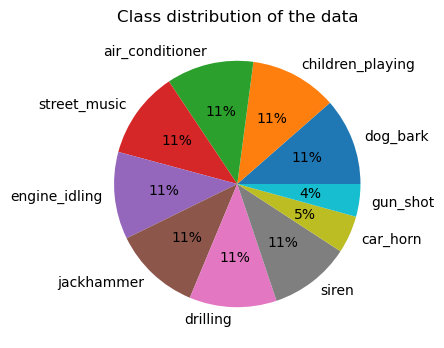

In [24]:
df['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(4,4))
plt.title('Class distribution of the data')
plt.ylabel('')
plt.show()

## Feature Extraction and Data Pre-processing 

It was believed that providing the raw data to the models would not yield significant results, even with the capabilities of Deep Learning models. In that sense, to enhance the learning of the models, a step of **Feature Extraction** was undertaken to feed the models processed data that would represent characteristics of the unprocessed data.

Furthermore, performing **Data Pre-Processing** was a necessary step, since the available data is composed  of a multitude of audio samples with different durations,  ranging from just a few milliseconds to 4 seconds of signal, giving the dataset an heterogeneous sample rate.

### Padding Audio Files fo fixed length

Regarding sample rate, all audio data were loaded from the .wav files and resampled to a sample rate of 22050 Hertz. In order to fix the duration of all samples to 4 seconds it was applied zero-padding to the signal until all samples had the same length.

In [25]:
def zero_padded_data_nparray(audios_path, duration_secs = 4, sr = 22050, files_limit = -1, verbose = False):

    files = librosa.util.find_files(audios_path)
    data_array = []

    for index, path_file in enumerate(files):
        if files_limit != -1 and index >= files_limit: break
        
        if verbose:
            print(f"At audio {index+1}/{len(files)}")
            
        signal, sr = librosa.load(path_file, sr = sr, mono=True)
        
        # zero padding
        if len(signal) < duration_secs*sr:
            signal = np.concatenate([
                signal,
                np.zeros(shape = (duration_secs*sr - len(signal), ))
            ])
        elif len(signal) > duration_secs*sr:
            signal = signal[:duration_secs*sr]
            

        if len(signal) == duration_secs*sr:
            lst = path_file.split("\\")
            file_name = lst[-1]
            newrow = [file_name, signal]
            data_array.append(newrow)
        else:
            print(file_name)
            print(path_file) 
        
    return data_array

### Feature extraction -> Log Mel Scaled Spectrograms


For the **LSTM model**, the group decided to used the **log scaled Mel Spectrograms** from the audio files.


A Mel Spectrogram visually depicts the frequency spectrum of an audio signal across time. It illustrates the strength of different frequency components in the audio by employing a colormap for intensity representation. This graphical representation presents audio data in a two-dimensional format, with time on the x-axis, frequency (log(Mel scaled)) on the y-axis, and color intensity indicating the amplitude or energy of each frequency component at distinct time points.


For this model, we decided to use a hop length of 512, and a number of Fast Fourier Transforms of 256.



189895-3-0-0.wav


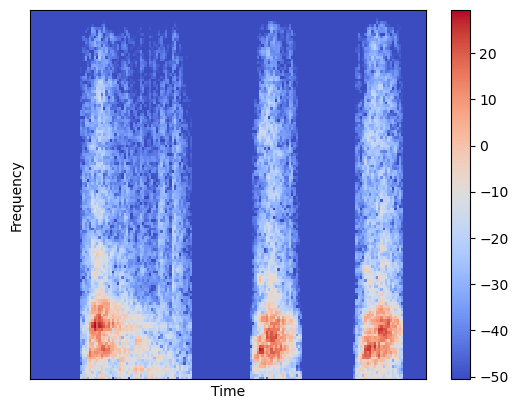

In [47]:
# choose a sample to plot
sample_num = 4729

# get the filename
filename = df.slice_file_name[sample_num] 
print(filename)

path = '../UrbanSound8K/audio/fold' + str(df.fold[sample_num]) + '/' + str(filename)
signal, sr = librosa.load(path, sr = 22050)

n_fft = 256
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectogram = np.abs(stft)
log_spectogram = librosa.amplitude_to_db(spectogram)

librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

Function to extract all Spectrograms:

In [27]:
def get_features(df_in, signals, hop_length = 512, n_fft = 256, sr = 44100):
    
    SPECTOGRAM = [] # list to save Spectograms
    labels = [] # list to save labels
    
    for index in range(len(signals)):

        # get the filename        
        filename = signals[index][0]
        if filename:
            
            # find correspondig row in df_in
            row = df_in.loc[df_in["slice_file_name"] == filename]

            if not row.empty:
                # save labels
                label = row.iloc[0,6] 

                # Extracting Spectograms
                stft = librosa.core.stft(y = np.array(signals[index][1]), 
                                         hop_length = hop_length, 
                                         n_fft =n_fft)
                spectogram = np.abs(stft)
                log_spectogram = librosa.amplitude_to_db(spectogram)

                SPECTOGRAM.append(np.array([log_spectogram]))
                
                # Extracting labels
                labels.append(label)
                
            else: 
                print(f"No matching row for filename {filename}")
        else:
            print("Empty filename")

    # check is features and labels  have the same lenght
    assert len(labels) == len(SPECTOGRAM)

    spec = np.concatenate(SPECTOGRAM, axis = 0)
    return(np.array(spec), labels)

### Data Preprocessing


Regarding data Preprocessing, two different techniques were adopted. Firstly, as a good practice, all data was **normalized**. This step was executed using the MinMaxScaler normalization method implemented by hand, which conveniently scaled all the data to the unit range for each feature's values.


Secondly, the target variable was **One-Hot Encoded**, meaning instead of having only one target column, we now have 10 columns, one for each possible class in the target feature.


To conclude, all data was then saved into **lists of np.Arrays**, to be used in the following model.

In [28]:
fold_paths = ["../UrbanSound8K/audio/fold1/", "../UrbanSound8K/audio/fold2/", "../UrbanSound8K/audio/fold3/",
              "../UrbanSound8K/audio/fold4/", "../UrbanSound8K/audio/fold5/", "../UrbanSound8K/audio/fold6/",
              "../UrbanSound8K/audio/fold7/", "../UrbanSound8K/audio/fold8/", "../UrbanSound8K/audio/fold9/",
              "../UrbanSound8K/audio/fold10/"]

spec = [10]
labels = [10]

for i in range(len(fold_paths)): 
    print(f"Starting fold {i+1}...")

    # Adding Zero-Padding to audio 
    audio = zero_padded_data_nparray(fold_paths[i])

    # Feature Extraction
    spectograms, y = get_features(df, audio)

    # Data Normalization Min-Max scaling to [0, 1] 
    spectograms_scaled = (spectograms - np.min(spectograms)) / (np.max(spectograms) - np.min(spectograms))

    # One-Hot Encoding Target feature
    y_encoded = np.zeros((len(y), max(y) +1))
    y_encoded[np.arange(len(y)), y] = 1

    # Saving Features and Labels to 
    spec.append(np.array(spectograms_scaled))
    labels.append(y_encoded)

    print(f"Done!")

features = spec[1:]
labels = labels[1:]


Starting fold 1...


Done!
Starting fold 2...
Done!
Starting fold 3...
Done!
Starting fold 4...
Done!
Starting fold 5...
Done!
Starting fold 6...
Done!
Starting fold 7...
Done!
Starting fold 8...
Done!
Starting fold 9...
Done!
Starting fold 10...
Done!


## Building the Recurrent Neural Network (LSTM)


The following model topology was the product of much trial and error, given that the group was not following any pre-made architecture.


For all layers, except the output, it was used the **Tanh activation function**. Over time, it gained popularity over the sigmoid function due to its superior performance in multi-layer neural networks. Regarding this project, Tanh activation function provided better results that sigmoid, and relu functions.




### Build Network topology


- **LSTM Layers**


    Firstly, the model strats two LSTM layers, each with 128 neurons. In contrast to a conventional RNN, which features a straightforward structure comprising input, hidden state, and output, an LSTM exhibits a more intricate design. It incorporates additional memory cells and gates, enabling selective retention or omission of information from preceding time steps. The LSTM's capacity to selectively retain or discard information from past time steps renders it highly effective for tasks involving the modeling of long-term dependencies, such as audio classification.


    By adding 'return_sequences = True', the LSTM layers are actually passing on a sequence of values, instead of single values.




- **Time Distributed Layers and Dropout**
   
    Since we are keeping a time dimension returned from LSTM layers, Time Distributed layers results were used to process this extra dimension.
    There are a total 6 Time distributed fully connected Dense Layers. In an attempt to reduce the dimensionality of our data, each subsequent layer possesses fewer neurons, starting at 256, reducing all the way to 8 neurons.


    Furthermore, in an attempt to reduce overfitting, L2 Weight Regularization was implemented in each layer, as well as the addition of 0.3 Dropout rate after each Dense Layer.




- **Flatten Layer**


    After using Time distributed Layers, the output consists of 2 dimensions, therefore to be able to compute one last softmax fully connected layer, we first needed to flatten out these 2 dimensions into 1 cohesive array of values. This is done by using a Flattten Layer.
   


- **Output Layer**


    Finally, the output layer of this neural network will consist of 10 fully connected neurons, since our target feature has 10 different classes. By using the sigmoid function, the output will consist in a probability distribution.


In [2]:
def create_model(x, y):
    input_shape = (x, y) # shape of X_train sample

    model = keras.Sequential()

    # 2 LSTM layers
    model.add(layers.LSTM(128,  input_shape = input_shape, return_sequences = True, activation='tanh', kernel_initializer='random_normal'))
    model.add(layers.LSTM(128, return_sequences = True, activation='tanh'))

    model.add(layers.TimeDistributed(layers.Dense(128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.01))))
    model.add(layers.Dropout(0.3))
    model.add(layers.TimeDistributed(layers.Dense(64, activation='tanh', kernel_regularizer = regularizers.l2(0.01))))
    model.add(layers.Dropout(0.3))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='tanh', kernel_regularizer = regularizers.l2(0.01))))
    model.add(layers.Dropout(0.3))
    model.add(layers.TimeDistributed(layers.Dense(16, activation='tanh', kernel_regularizer = regularizers.l2(0.01))))
    model.add(layers.Dropout(0.3))
    model.add(layers.TimeDistributed(layers.Dense(8, activation='tanh', kernel_regularizer = regularizers.l2(0.01))))
    model.add(layers.Dropout(0.3))

    # Flatten layer 
    model.add(layers.Flatten())

    # Output layer
    model.add(layers.Dense(10, activation = 'softmax'))

    return model

In [3]:
model = create_model(129, 173)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 129, 128)          154624    
                                                                 
 lstm_1 (LSTM)               (None, 129, 128)          131584    
                                                                 
 time_distributed (TimeDist  (None, 129, 128)          16512     
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 129, 128)          0         
                                                                 
 time_distributed_1 (TimeDi  (None, 129, 64)           8256      
 stributed)                                                      
                                                                 
 dropout_1 (Dropout)         (None, 129, 64)           

We can also plot the graph of the LSTM:

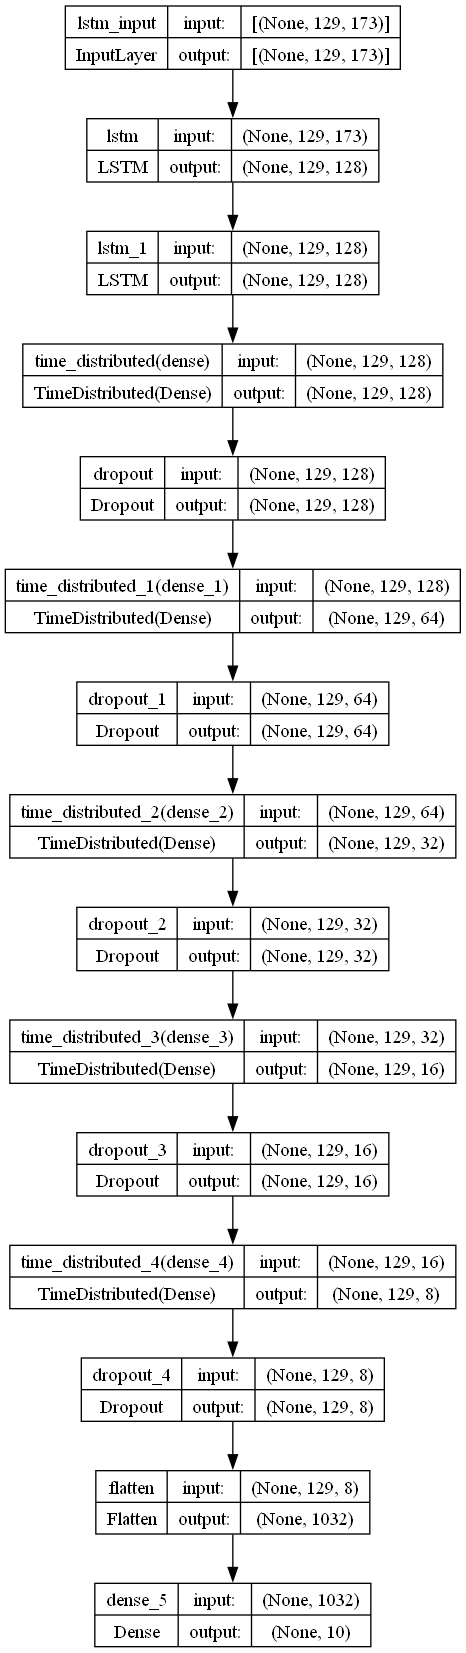

In [4]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

## Metric Variables

To analyse the 10 models made in the 10 fold cross validation, we will keep useful information in an array.

In [41]:
fold_metrics = []

We will also be saving these metrics in Pickle files, for further usage. 
File Load / Save with Pickle:

In [42]:
def save_pkl(data, path):
    with open(path, "wb") as saved_data:
        pickle.dump(data, saved_data)
    saved_data.close()

def load_pkl(path):
    to_return = None
    with open(path, "rb") as loaded_data:
        to_return = pickle.load(loaded_data)
    loaded_data.close()
    return to_return

## 10-Fold Cross Validation

During the hypertunning of this model there were used 2 different optimizers, Adam and Stochastic Gradient Descent. The one who yield a better performance was **Adam Optimizer** with a learning rate of 0.001.

For this classification problem, the error function will be **categorical cross-entropy**, since the target label is One-Hot Encoded. Finally, we will use **accuracy** to analyze how well our model performs.

During training, the **batch size** will be 64 samples, and, from previous testings, we will defined the **number of epochs** to 50. This number helps us keep a great balance between run-time and overfitting in the model, since adding more epochs takes too much time to train.

In [46]:
EPOCHS = 50

for fold in range(10):
    f = "fold" + str(fold+1)
    print("Fold "+str(fold+1)+":")

    X_train, y_train = [], []
    X_test, y_test = [], []
        
    # Splitting the data into Test, Validation and Training sets
    for i in range(10):
        if( i != fold):
            X_train += features[i].tolist()
            y_train.extend(labels[i])
            
        else:
            X_test = features[i]
            y_test = labels[i]

        
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
            
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 123)

    # Print sets shapes
    print(f"X_train Shape: {X_train.shape}")
    print(f"X_test Shape: {X_test.shape}")
    print(f"X_val Shape: {X_val.shape}")

    # Create & Compile model
    model = create_model(X_train.shape[1], X_train.shape[2])
    optimizer = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(
        optimizer = optimizer, 
        loss = 'categorical_crossentropy', 
        metrics=['accuracy']
    )

    # Train model
    LSTM = model.fit(
        X_train, y_train, 
        epochs = EPOCHS,
        batch_size = 64, 
        shuffle = False, 
        validation_data=(X_val, y_val)
    )

    # Predict unseen data
    y_pred = model.predict(X_test)

    y_pred_reshape = np.argmax(y_pred, axis=1)
    y_test_reshape = np.argmax(y_test, axis=1)
    TestLoss, Testacc = model.evaluate(X_test, y_test)
    
    # Save fold results
    m_metrics = {
        'loss': TestLoss, 
        'accuracy': Testacc, 
        'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
        'history': model, 'history_dict': LSTM.history
    }
    
    fold_metrics.append(m_metrics)

    model.save(f"kfold_metrics_LSTM/model_fold{fold+1}.keras", save_format="keras")
    save_pkl(fold_metrics, f"kfold_metrics_LSTM/metrics{fold+1}.pkl")

    # restart model to avoid memory leakage
    del model 

    print("Done.")


Fold 1:
X_train Shape: (7859, 129, 173)
X_test Shape: (436, 129, 173)
X_val Shape: (437, 129, 173)
Epoch 1/50
123/123 [==============================] - 63s 441ms/step - loss: 4.6638 - accuracy: 0.1139 - val_loss: 3.9062 - val_accuracy: 0.2220
Epoch 2/50
123/123 [==============================] - 53s 428ms/step - loss: 3.5457 - accuracy: 0.1719 - val_loss: 3.0773 - val_accuracy: 0.1556
Epoch 3/50
123/123 [==============================] - 56s 455ms/step - loss: 2.9230 - accuracy: 0.1911 - val_loss: 2.6312 - val_accuracy: 0.2426
Epoch 4/50
123/123 [==============================] - 65s 527ms/step - loss: 2.5811 - accuracy: 0.2080 - val_loss: 2.3192 - val_accuracy: 0.2815
Epoch 5/50
123/123 [==============================] - 60s 488ms/step - loss: 2.3783 - accuracy: 0.2280 - val_loss: 2.1754 - val_accuracy: 0.2677
Epoch 6/50
123/123 [==============================] - 53s 433ms/step - loss: 2.2520 - accuracy: 0.2458 - val_loss: 2.0642 - val_accuracy: 0.2860
Epoch 7/50
123/123 [===========

INFO:tensorflow:Assets written to: ram://324b0db8-d478-4bef-b795-107458d6fd11/assets


INFO:tensorflow:Assets written to: ram://324b0db8-d478-4bef-b795-107458d6fd11/assets


INFO:tensorflow:Assets written to: ram://d11b99ee-9bdc-433f-a1c8-9d04a64903db/assets


INFO:tensorflow:Assets written to: ram://d11b99ee-9bdc-433f-a1c8-9d04a64903db/assets


Done.
Fold 2:
X_train Shape: (7844, 129, 173)
X_test Shape: (444, 129, 173)
X_val Shape: (444, 129, 173)
Epoch 1/50
123/123 [==============================] - 58s 403ms/step - loss: 4.6194 - accuracy: 0.1096 - val_loss: 3.8643 - val_accuracy: 0.2027
Epoch 2/50
123/123 [==============================] - 56s 454ms/step - loss: 3.4995 - accuracy: 0.1455 - val_loss: 3.0968 - val_accuracy: 0.2342
Epoch 3/50
123/123 [==============================] - 55s 445ms/step - loss: 2.8435 - accuracy: 0.1689 - val_loss: 2.5364 - val_accuracy: 0.2387
Epoch 4/50
123/123 [==============================] - 52s 421ms/step - loss: 2.4725 - accuracy: 0.2114 - val_loss: 2.3305 - val_accuracy: 0.2860
Epoch 5/50
123/123 [==============================] - 51s 411ms/step - loss: 2.2745 - accuracy: 0.2357 - val_loss: 2.2333 - val_accuracy: 0.2838
Epoch 6/50
123/123 [==============================] - 51s 411ms/step - loss: 2.1659 - accuracy: 0.2477 - val_loss: 2.1877 - val_accuracy: 0.2590
Epoch 7/50
123/123 [=====

INFO:tensorflow:Assets written to: ram://99a61c32-bed5-46b3-93e9-7f10b8f8f356/assets


INFO:tensorflow:Assets written to: ram://99a61c32-bed5-46b3-93e9-7f10b8f8f356/assets


INFO:tensorflow:Assets written to: ram://84864b5b-6bfa-48ce-9003-ddea063a2b9a/assets


INFO:tensorflow:Assets written to: ram://84864b5b-6bfa-48ce-9003-ddea063a2b9a/assets


INFO:tensorflow:Assets written to: ram://f44ede14-5a87-4745-a009-a9449744bd23/assets


INFO:tensorflow:Assets written to: ram://f44ede14-5a87-4745-a009-a9449744bd23/assets


Done.
Fold 3:
X_train Shape: (7807, 129, 173)
X_test Shape: (462, 129, 173)
X_val Shape: (463, 129, 173)
Epoch 1/50
122/122 [==============================] - 56s 385ms/step - loss: 4.7107 - accuracy: 0.1008 - val_loss: 3.9308 - val_accuracy: 0.1836
Epoch 2/50
122/122 [==============================] - 45s 368ms/step - loss: 3.5556 - accuracy: 0.1654 - val_loss: 3.1948 - val_accuracy: 0.1706
Epoch 3/50
122/122 [==============================] - 46s 373ms/step - loss: 2.9413 - accuracy: 0.2021 - val_loss: 2.7299 - val_accuracy: 0.1771
Epoch 4/50
122/122 [==============================] - 46s 377ms/step - loss: 2.5893 - accuracy: 0.2069 - val_loss: 2.4020 - val_accuracy: 0.1965
Epoch 5/50
122/122 [==============================] - 46s 378ms/step - loss: 2.3736 - accuracy: 0.2320 - val_loss: 2.2227 - val_accuracy: 0.2981
Epoch 6/50
122/122 [==============================] - 46s 379ms/step - loss: 2.2370 - accuracy: 0.2512 - val_loss: 2.1593 - val_accuracy: 0.2246
Epoch 7/50
122/122 [=====

INFO:tensorflow:Assets written to: ram://4b7b0474-7660-4b1d-ac29-dbbc5baf7bb6/assets


INFO:tensorflow:Assets written to: ram://4b7b0474-7660-4b1d-ac29-dbbc5baf7bb6/assets


INFO:tensorflow:Assets written to: ram://53939071-9281-4ef9-818a-f83785d48176/assets


INFO:tensorflow:Assets written to: ram://53939071-9281-4ef9-818a-f83785d48176/assets


INFO:tensorflow:Assets written to: ram://38919a91-ac80-4a41-a3ea-929787234413/assets


INFO:tensorflow:Assets written to: ram://38919a91-ac80-4a41-a3ea-929787234413/assets


INFO:tensorflow:Assets written to: ram://9b76a1b0-00e4-44fb-8f77-1931d74e445a/assets


INFO:tensorflow:Assets written to: ram://9b76a1b0-00e4-44fb-8f77-1931d74e445a/assets


Done.
Fold 4:
X_train Shape: (7742, 129, 173)
X_test Shape: (495, 129, 173)
X_val Shape: (495, 129, 173)
Epoch 1/50
121/121 [==============================] - 74s 487ms/step - loss: 4.5739 - accuracy: 0.1182 - val_loss: 3.8018 - val_accuracy: 0.1313
Epoch 2/50
121/121 [==============================] - 55s 453ms/step - loss: 3.3665 - accuracy: 0.1979 - val_loss: 3.0009 - val_accuracy: 0.2384
Epoch 3/50
121/121 [==============================] - 54s 443ms/step - loss: 2.7629 - accuracy: 0.2162 - val_loss: 2.6162 - val_accuracy: 0.1758
Epoch 4/50
121/121 [==============================] - 52s 427ms/step - loss: 2.4418 - accuracy: 0.2343 - val_loss: 2.3848 - val_accuracy: 0.2343
Epoch 5/50
121/121 [==============================] - 54s 442ms/step - loss: 2.2659 - accuracy: 0.2377 - val_loss: 2.2514 - val_accuracy: 0.2687
Epoch 6/50
121/121 [==============================] - 51s 417ms/step - loss: 2.1568 - accuracy: 0.2592 - val_loss: 2.1595 - val_accuracy: 0.2727
Epoch 7/50
121/121 [=====

INFO:tensorflow:Assets written to: ram://136d0efb-9ba7-4922-819c-bf41a6d33a91/assets


INFO:tensorflow:Assets written to: ram://136d0efb-9ba7-4922-819c-bf41a6d33a91/assets


INFO:tensorflow:Assets written to: ram://054b280c-e86d-41df-8cd4-f930fbec4358/assets


INFO:tensorflow:Assets written to: ram://054b280c-e86d-41df-8cd4-f930fbec4358/assets


INFO:tensorflow:Assets written to: ram://683af07d-f088-4f27-972e-cd49ccc59a90/assets


INFO:tensorflow:Assets written to: ram://683af07d-f088-4f27-972e-cd49ccc59a90/assets


INFO:tensorflow:Assets written to: ram://fdab81b0-a517-45a1-ba49-3a0f2a5a4c76/assets


INFO:tensorflow:Assets written to: ram://fdab81b0-a517-45a1-ba49-3a0f2a5a4c76/assets


INFO:tensorflow:Assets written to: ram://eb653844-399b-45ae-9d54-120a50c0db85/assets


INFO:tensorflow:Assets written to: ram://eb653844-399b-45ae-9d54-120a50c0db85/assets


Done.
Fold 5:
X_train Shape: (7796, 129, 173)
X_test Shape: (468, 129, 173)
X_val Shape: (468, 129, 173)
Epoch 1/50
122/122 [==============================] - 59s 405ms/step - loss: 4.6284 - accuracy: 0.1136 - val_loss: 3.9074 - val_accuracy: 0.1090
Epoch 2/50
122/122 [==============================] - 48s 391ms/step - loss: 3.4365 - accuracy: 0.1786 - val_loss: 3.1323 - val_accuracy: 0.2030
Epoch 3/50
122/122 [==============================] - 48s 393ms/step - loss: 2.8489 - accuracy: 0.2118 - val_loss: 2.7593 - val_accuracy: 0.1667
Epoch 4/50
122/122 [==============================] - 49s 400ms/step - loss: 2.5302 - accuracy: 0.2128 - val_loss: 2.4709 - val_accuracy: 0.2265
Epoch 5/50
122/122 [==============================] - 49s 399ms/step - loss: 2.3323 - accuracy: 0.2295 - val_loss: 2.3706 - val_accuracy: 0.1966
Epoch 6/50
122/122 [==============================] - 51s 416ms/step - loss: 2.2166 - accuracy: 0.2379 - val_loss: 2.2845 - val_accuracy: 0.2073
Epoch 7/50
122/122 [=====

INFO:tensorflow:Assets written to: ram://4b68bd43-7de4-46e0-b406-6de490697bd1/assets


INFO:tensorflow:Assets written to: ram://4b68bd43-7de4-46e0-b406-6de490697bd1/assets


INFO:tensorflow:Assets written to: ram://3130c14b-5249-4915-ab0e-92510cf72279/assets


INFO:tensorflow:Assets written to: ram://3130c14b-5249-4915-ab0e-92510cf72279/assets


INFO:tensorflow:Assets written to: ram://85682be2-85b4-47ac-a496-e86c9ff9d2fd/assets


INFO:tensorflow:Assets written to: ram://85682be2-85b4-47ac-a496-e86c9ff9d2fd/assets


INFO:tensorflow:Assets written to: ram://bc7f0375-713b-4b2e-9eb7-30e429a41dd1/assets


INFO:tensorflow:Assets written to: ram://bc7f0375-713b-4b2e-9eb7-30e429a41dd1/assets


INFO:tensorflow:Assets written to: ram://c420f105-8455-486a-9ac4-dea9960b5f53/assets


INFO:tensorflow:Assets written to: ram://c420f105-8455-486a-9ac4-dea9960b5f53/assets


INFO:tensorflow:Assets written to: ram://a7363870-00e5-4645-ae0f-a958ac39837e/assets


INFO:tensorflow:Assets written to: ram://a7363870-00e5-4645-ae0f-a958ac39837e/assets


Done.
Fold 6:
X_train Shape: (7909, 129, 173)
X_test Shape: (411, 129, 173)
X_val Shape: (412, 129, 173)
Epoch 1/50
124/124 [==============================] - 60s 401ms/step - loss: 4.7308 - accuracy: 0.0986 - val_loss: 3.9473 - val_accuracy: 0.1238
Epoch 2/50
124/124 [==============================] - 48s 384ms/step - loss: 3.5293 - accuracy: 0.1670 - val_loss: 3.1011 - val_accuracy: 0.1335
Epoch 3/50
124/124 [==============================] - 48s 389ms/step - loss: 2.9226 - accuracy: 0.1998 - val_loss: 2.6538 - val_accuracy: 0.1845
Epoch 4/50
124/124 [==============================] - 51s 408ms/step - loss: 2.5653 - accuracy: 0.2158 - val_loss: 2.3803 - val_accuracy: 0.2087
Epoch 5/50
124/124 [==============================] - 49s 396ms/step - loss: 2.3584 - accuracy: 0.2381 - val_loss: 2.2166 - val_accuracy: 0.2864
Epoch 6/50
124/124 [==============================] - 50s 403ms/step - loss: 2.2392 - accuracy: 0.2399 - val_loss: 2.1322 - val_accuracy: 0.2500
Epoch 7/50
124/124 [=====

INFO:tensorflow:Assets written to: ram://aee68235-f806-4020-a1bd-9576374a44fd/assets


INFO:tensorflow:Assets written to: ram://aee68235-f806-4020-a1bd-9576374a44fd/assets


INFO:tensorflow:Assets written to: ram://6081658a-a47f-4ab0-a361-9d47e15c5c4d/assets


INFO:tensorflow:Assets written to: ram://6081658a-a47f-4ab0-a361-9d47e15c5c4d/assets


INFO:tensorflow:Assets written to: ram://74e837d5-56fc-4dd8-8b31-972f54425bad/assets


INFO:tensorflow:Assets written to: ram://74e837d5-56fc-4dd8-8b31-972f54425bad/assets


INFO:tensorflow:Assets written to: ram://0d3887f0-d8d6-4ddd-8b87-48c96baf4f2a/assets


INFO:tensorflow:Assets written to: ram://0d3887f0-d8d6-4ddd-8b87-48c96baf4f2a/assets


INFO:tensorflow:Assets written to: ram://442d5c8c-c59e-4aba-a8a7-38a4ac30a35e/assets


INFO:tensorflow:Assets written to: ram://442d5c8c-c59e-4aba-a8a7-38a4ac30a35e/assets


INFO:tensorflow:Assets written to: ram://5de6aee2-82dc-4150-9fa9-119513f69e9b/assets


INFO:tensorflow:Assets written to: ram://5de6aee2-82dc-4150-9fa9-119513f69e9b/assets


INFO:tensorflow:Assets written to: ram://9c05955d-19f0-4dc0-9da7-c953280547d3/assets


INFO:tensorflow:Assets written to: ram://9c05955d-19f0-4dc0-9da7-c953280547d3/assets


Done.
Fold 7:
X_train Shape: (7894, 129, 173)
X_test Shape: (419, 129, 173)
X_val Shape: (419, 129, 173)
Epoch 1/50
124/124 [==============================] - 64s 429ms/step - loss: 4.6690 - accuracy: 0.0989 - val_loss: 3.8726 - val_accuracy: 0.1671
Epoch 2/50
124/124 [==============================] - 48s 388ms/step - loss: 3.5104 - accuracy: 0.1411 - val_loss: 3.1359 - val_accuracy: 0.1575
Epoch 3/50
124/124 [==============================] - 49s 398ms/step - loss: 2.9055 - accuracy: 0.1719 - val_loss: 2.5910 - val_accuracy: 0.2124
Epoch 4/50
124/124 [==============================] - 50s 401ms/step - loss: 2.5641 - accuracy: 0.2061 - val_loss: 2.3858 - val_accuracy: 0.2291
Epoch 5/50
124/124 [==============================] - 52s 416ms/step - loss: 2.3475 - accuracy: 0.2259 - val_loss: 2.2592 - val_accuracy: 0.2387
Epoch 6/50
124/124 [==============================] - 52s 421ms/step - loss: 2.2237 - accuracy: 0.2347 - val_loss: 2.1590 - val_accuracy: 0.2387
Epoch 7/50
124/124 [=====

INFO:tensorflow:Assets written to: ram://5f1bce24-cf49-47a2-b3ad-f62449aa66c1/assets


INFO:tensorflow:Assets written to: ram://5f1bce24-cf49-47a2-b3ad-f62449aa66c1/assets


INFO:tensorflow:Assets written to: ram://a5bb4c4b-d2fa-4faf-9809-5ecbdfbc86d8/assets


INFO:tensorflow:Assets written to: ram://a5bb4c4b-d2fa-4faf-9809-5ecbdfbc86d8/assets


INFO:tensorflow:Assets written to: ram://8536df35-1523-4e53-b44b-e666b4a6bc9e/assets


INFO:tensorflow:Assets written to: ram://8536df35-1523-4e53-b44b-e666b4a6bc9e/assets


INFO:tensorflow:Assets written to: ram://9336795f-f1e5-49ad-ba8d-cb2915764da9/assets


INFO:tensorflow:Assets written to: ram://9336795f-f1e5-49ad-ba8d-cb2915764da9/assets


INFO:tensorflow:Assets written to: ram://2fda137d-94f3-4ce5-94b7-584ccde08383/assets


INFO:tensorflow:Assets written to: ram://2fda137d-94f3-4ce5-94b7-584ccde08383/assets


INFO:tensorflow:Assets written to: ram://541e3c49-486f-4773-ab56-91333f6c4f54/assets


INFO:tensorflow:Assets written to: ram://541e3c49-486f-4773-ab56-91333f6c4f54/assets


INFO:tensorflow:Assets written to: ram://952535bd-5f72-485f-84ce-db44c136404c/assets


INFO:tensorflow:Assets written to: ram://952535bd-5f72-485f-84ce-db44c136404c/assets


INFO:tensorflow:Assets written to: ram://6437e810-9f59-40fc-bc8b-88ad90e2b244/assets


INFO:tensorflow:Assets written to: ram://6437e810-9f59-40fc-bc8b-88ad90e2b244/assets


Done.
Fold 8:
X_train Shape: (7926, 129, 173)
X_test Shape: (403, 129, 173)
X_val Shape: (403, 129, 173)
Epoch 1/50
124/124 [==============================] - 62s 431ms/step - loss: 4.7573 - accuracy: 0.1081 - val_loss: 3.8435 - val_accuracy: 0.2159
Epoch 2/50
124/124 [==============================] - 50s 403ms/step - loss: 3.5777 - accuracy: 0.1607 - val_loss: 3.0916 - val_accuracy: 0.1638
Epoch 3/50
124/124 [==============================] - 51s 413ms/step - loss: 2.9572 - accuracy: 0.1962 - val_loss: 2.6497 - val_accuracy: 0.2308
Epoch 4/50
124/124 [==============================] - 53s 426ms/step - loss: 2.6092 - accuracy: 0.2096 - val_loss: 2.3803 - val_accuracy: 0.2556
Epoch 5/50
124/124 [==============================] - 54s 433ms/step - loss: 2.4055 - accuracy: 0.2210 - val_loss: 2.2301 - val_accuracy: 0.2655
Epoch 6/50
124/124 [==============================] - 53s 428ms/step - loss: 2.2786 - accuracy: 0.2354 - val_loss: 2.1166 - val_accuracy: 0.2878
Epoch 7/50
124/124 [=====

INFO:tensorflow:Assets written to: ram://098b3041-afca-4d56-9606-66a64596b114/assets


INFO:tensorflow:Assets written to: ram://098b3041-afca-4d56-9606-66a64596b114/assets


INFO:tensorflow:Assets written to: ram://eddbfe14-3320-47f4-8d3b-c62b97959711/assets


INFO:tensorflow:Assets written to: ram://eddbfe14-3320-47f4-8d3b-c62b97959711/assets


INFO:tensorflow:Assets written to: ram://20a4fc90-c000-4a2e-8b55-ffcc0e1b87e2/assets


INFO:tensorflow:Assets written to: ram://20a4fc90-c000-4a2e-8b55-ffcc0e1b87e2/assets


INFO:tensorflow:Assets written to: ram://e60d72ca-d677-42c3-8cfe-52857611a2ec/assets


INFO:tensorflow:Assets written to: ram://e60d72ca-d677-42c3-8cfe-52857611a2ec/assets


INFO:tensorflow:Assets written to: ram://6f5d2f28-f3d1-4c09-aecd-fc60c70928ff/assets


INFO:tensorflow:Assets written to: ram://6f5d2f28-f3d1-4c09-aecd-fc60c70928ff/assets


INFO:tensorflow:Assets written to: ram://5cd4312a-c229-40a1-b2f9-437911ba126b/assets


INFO:tensorflow:Assets written to: ram://5cd4312a-c229-40a1-b2f9-437911ba126b/assets


INFO:tensorflow:Assets written to: ram://a4275306-fae2-4db8-8f9f-7495713de19b/assets


INFO:tensorflow:Assets written to: ram://a4275306-fae2-4db8-8f9f-7495713de19b/assets


INFO:tensorflow:Assets written to: ram://9c857ff0-e44d-4817-8fe1-10e5886e20e0/assets


INFO:tensorflow:Assets written to: ram://9c857ff0-e44d-4817-8fe1-10e5886e20e0/assets


INFO:tensorflow:Assets written to: ram://c51aaa7b-5672-4b2c-b6d2-0c9559334849/assets


INFO:tensorflow:Assets written to: ram://c51aaa7b-5672-4b2c-b6d2-0c9559334849/assets


Done.
Fold 9:
X_train Shape: (7916, 129, 173)
X_test Shape: (408, 129, 173)
X_val Shape: (408, 129, 173)
Epoch 1/50
124/124 [==============================] - 60s 417ms/step - loss: 4.7097 - accuracy: 0.1031 - val_loss: 3.8438 - val_accuracy: 0.1887
Epoch 2/50
124/124 [==============================] - 50s 404ms/step - loss: 3.5191 - accuracy: 0.1570 - val_loss: 3.0963 - val_accuracy: 0.1814
Epoch 3/50
124/124 [==============================] - 50s 403ms/step - loss: 2.9555 - accuracy: 0.1925 - val_loss: 2.6291 - val_accuracy: 0.2770
Epoch 4/50
124/124 [==============================] - 53s 425ms/step - loss: 2.6186 - accuracy: 0.2239 - val_loss: 2.3833 - val_accuracy: 0.2745
Epoch 5/50
124/124 [==============================] - 53s 429ms/step - loss: 2.4094 - accuracy: 0.2442 - val_loss: 2.2302 - val_accuracy: 0.2819
Epoch 6/50
124/124 [==============================] - 54s 434ms/step - loss: 2.2781 - accuracy: 0.2515 - val_loss: 2.1178 - val_accuracy: 0.2770
Epoch 7/50
124/124 [=====

INFO:tensorflow:Assets written to: ram://43d1f584-ebc0-4be6-a5be-b018923c7845/assets


INFO:tensorflow:Assets written to: ram://43d1f584-ebc0-4be6-a5be-b018923c7845/assets


INFO:tensorflow:Assets written to: ram://ccd779f1-9e75-4b4a-8512-a2d52c1c86e0/assets


INFO:tensorflow:Assets written to: ram://ccd779f1-9e75-4b4a-8512-a2d52c1c86e0/assets


INFO:tensorflow:Assets written to: ram://d8fe9d03-7ad6-4649-9f41-d8a81f338ea9/assets


INFO:tensorflow:Assets written to: ram://d8fe9d03-7ad6-4649-9f41-d8a81f338ea9/assets


INFO:tensorflow:Assets written to: ram://38377c26-4572-41bd-96f7-aeb476b0c4d8/assets


INFO:tensorflow:Assets written to: ram://38377c26-4572-41bd-96f7-aeb476b0c4d8/assets


INFO:tensorflow:Assets written to: ram://276dd0e8-37a2-4408-845e-a472d5019f92/assets


INFO:tensorflow:Assets written to: ram://276dd0e8-37a2-4408-845e-a472d5019f92/assets


INFO:tensorflow:Assets written to: ram://be105a47-3b1d-4c9e-b7cd-a170bf6a60c5/assets


INFO:tensorflow:Assets written to: ram://be105a47-3b1d-4c9e-b7cd-a170bf6a60c5/assets


INFO:tensorflow:Assets written to: ram://4c0dee34-68c7-40d9-b101-9878aae86e7e/assets


INFO:tensorflow:Assets written to: ram://4c0dee34-68c7-40d9-b101-9878aae86e7e/assets


INFO:tensorflow:Assets written to: ram://3e9780e0-951b-4f4c-9d8b-f2f123e2a61c/assets


INFO:tensorflow:Assets written to: ram://3e9780e0-951b-4f4c-9d8b-f2f123e2a61c/assets


INFO:tensorflow:Assets written to: ram://a40d296c-881c-4a08-ae22-39315c9a020b/assets


INFO:tensorflow:Assets written to: ram://a40d296c-881c-4a08-ae22-39315c9a020b/assets


INFO:tensorflow:Assets written to: ram://b79cc84b-396a-4b29-9cbc-533e813b4c8d/assets


INFO:tensorflow:Assets written to: ram://b79cc84b-396a-4b29-9cbc-533e813b4c8d/assets


Done.
Fold 10:
X_train Shape: (7895, 129, 173)
X_test Shape: (418, 129, 173)
X_val Shape: (419, 129, 173)
Epoch 1/50
124/124 [==============================] - 64s 447ms/step - loss: 4.6635 - accuracy: 0.0998 - val_loss: 3.8940 - val_accuracy: 0.1241
Epoch 2/50
124/124 [==============================] - 53s 430ms/step - loss: 3.5337 - accuracy: 0.1389 - val_loss: 3.0169 - val_accuracy: 0.2220
Epoch 3/50
124/124 [==============================] - 56s 449ms/step - loss: 2.8752 - accuracy: 0.1851 - val_loss: 2.5132 - val_accuracy: 0.2745
Epoch 4/50
124/124 [==============================] - 56s 456ms/step - loss: 2.5134 - accuracy: 0.2180 - val_loss: 2.3158 - val_accuracy: 0.2267
Epoch 5/50
124/124 [==============================] - 57s 459ms/step - loss: 2.3110 - accuracy: 0.2447 - val_loss: 2.1232 - val_accuracy: 0.2936
Epoch 6/50
124/124 [==============================] - 58s 469ms/step - loss: 2.1722 - accuracy: 0.2532 - val_loss: 2.0503 - val_accuracy: 0.2888
Epoch 7/50
124/124 [====

INFO:tensorflow:Assets written to: ram://20ca8731-bc4e-40a3-9d25-461af39c7cc6/assets


INFO:tensorflow:Assets written to: ram://20ca8731-bc4e-40a3-9d25-461af39c7cc6/assets


INFO:tensorflow:Assets written to: ram://0f137225-15bb-41a7-bd3f-7014fd9ef376/assets


INFO:tensorflow:Assets written to: ram://0f137225-15bb-41a7-bd3f-7014fd9ef376/assets


INFO:tensorflow:Assets written to: ram://281ccb69-fb5c-47fd-a624-98505f426d54/assets


INFO:tensorflow:Assets written to: ram://281ccb69-fb5c-47fd-a624-98505f426d54/assets


INFO:tensorflow:Assets written to: ram://cd500501-8f58-493d-af39-3f97a16cbe8d/assets


INFO:tensorflow:Assets written to: ram://cd500501-8f58-493d-af39-3f97a16cbe8d/assets


INFO:tensorflow:Assets written to: ram://987861e6-6196-4700-8c76-f6e4363f4201/assets


INFO:tensorflow:Assets written to: ram://987861e6-6196-4700-8c76-f6e4363f4201/assets


INFO:tensorflow:Assets written to: ram://577d49ed-cbb4-4770-ab9c-5cfb5211a22f/assets


INFO:tensorflow:Assets written to: ram://577d49ed-cbb4-4770-ab9c-5cfb5211a22f/assets


INFO:tensorflow:Assets written to: ram://9fa28c3a-9b0f-4388-bf21-71a97cc198f5/assets


INFO:tensorflow:Assets written to: ram://9fa28c3a-9b0f-4388-bf21-71a97cc198f5/assets


INFO:tensorflow:Assets written to: ram://36278d22-ed4c-4ac3-8e22-9b4d65c37729/assets


INFO:tensorflow:Assets written to: ram://36278d22-ed4c-4ac3-8e22-9b4d65c37729/assets


INFO:tensorflow:Assets written to: ram://b0f20378-f280-4901-afa6-092470d5d28f/assets


INFO:tensorflow:Assets written to: ram://b0f20378-f280-4901-afa6-092470d5d28f/assets


INFO:tensorflow:Assets written to: ram://6c0d1bd7-8b62-4c64-8ac8-b3689640a3cb/assets


INFO:tensorflow:Assets written to: ram://6c0d1bd7-8b62-4c64-8ac8-b3689640a3cb/assets


INFO:tensorflow:Assets written to: ram://440d97a7-604c-4617-9456-d3ba8521fb80/assets


INFO:tensorflow:Assets written to: ram://440d97a7-604c-4617-9456-d3ba8521fb80/assets


Done.


##  Model Analysis

### Accuracy & Loss

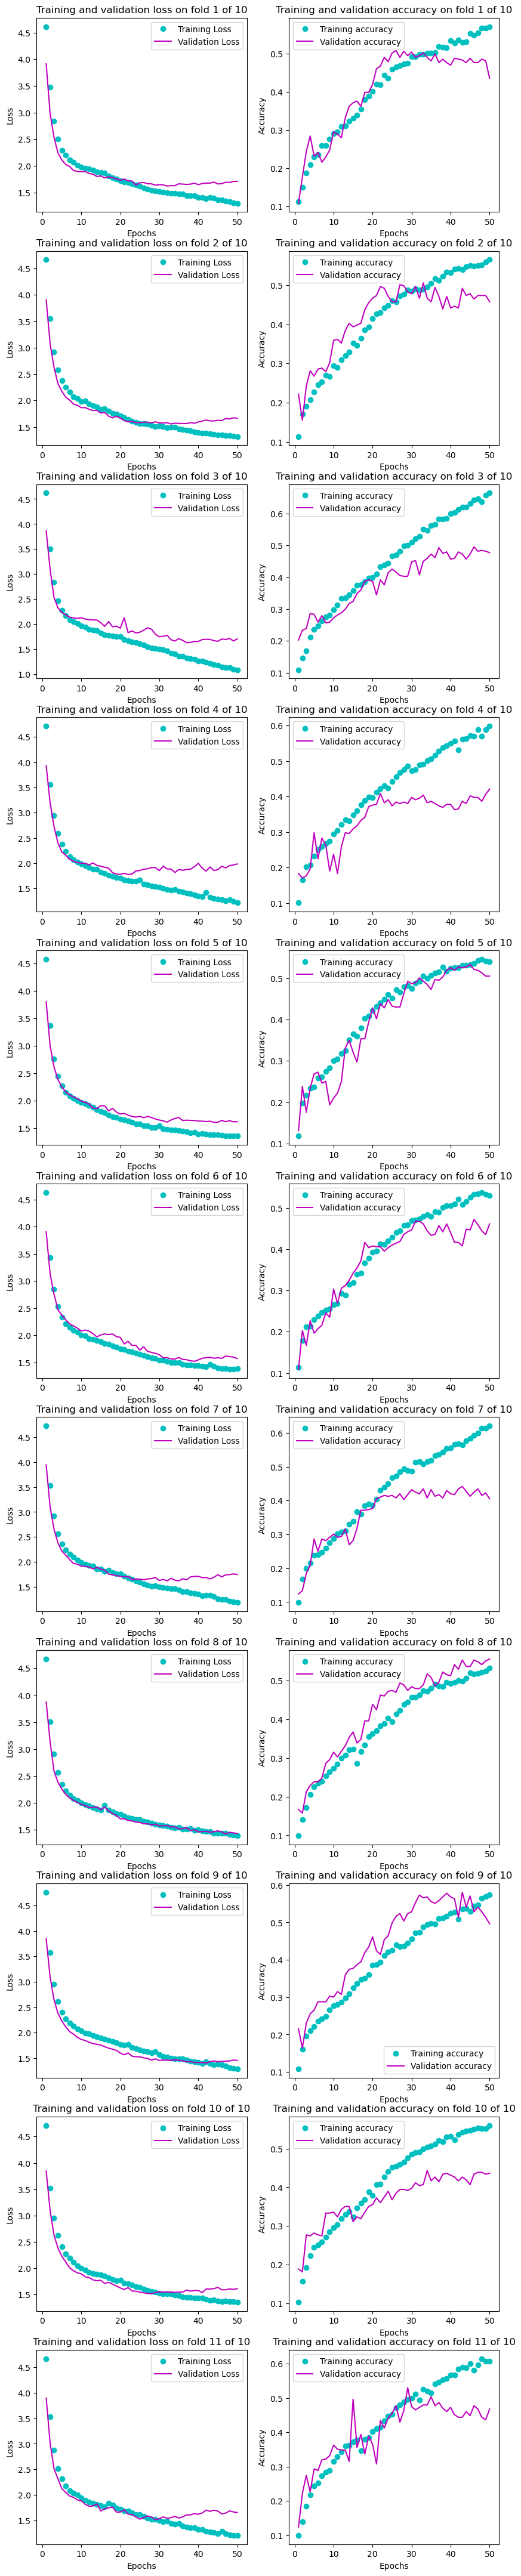

In [48]:
epochs = range(1, EPOCHS + 1)

fig, ax = plt.subplots(len(fold_metrics), 2, figsize=(10, 5*len(fold_metrics)))

for i in range(0,len(fold_metrics)):
    history_dict = fold_metrics[i].get('history_dict')
    loss_values=history_dict['loss']
    acc_values=history_dict['accuracy']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    ax[i,0].plot(epochs,loss_values,'co',label='Training Loss')
    ax[i,0].plot(epochs,val_loss_values,'m', label='Validation Loss')
    ax[i,0].set_title('Training and validation loss on fold '+str(i+1)+' of 10')
    ax[i,0].set_xlabel('Epochs')
    ax[i,0].set_ylabel('Loss')
    ax[i,0].legend()

    ax[i,1].plot(epochs,acc_values,'co', label='Training accuracy')
    ax[i,1].plot(epochs,val_acc_values,'m', label='Validation accuracy')
    ax[i,1].set_title('Training and validation accuracy on fold '+str(i+1)+' of 10')
    ax[i,1].set_xlabel('Epochs')
    ax[i,1].set_ylabel('Accuracy')
    ax[i,1].legend()
plt.show()

It's important to acknowledge that since the loss is continuous and the class labels are categorical, there may be seemingly random fluctuations in the validation accuracy. This phenomenon arises because, as the loss decreases, certain classifications might momentarily be assigned incorrectly, even though the model is progressively approaching accurate classifications. This is evident in the "rubber banding" effect, where accuracy catches up with the training loss over additional epochs.

### Average Accuracy and Standard Deviation

In [49]:
avg_train_acc = 0
train_lst = []
for i in fold_metrics:
    avg_train_acc += max(i.get('history_dict').get('accuracy'))
    train_lst.append(max(i.get('history_dict').get('accuracy')))
    
print("%.4f +- %.4f average train accuracy across all folds." % (avg_train_acc/len(fold_metrics) , np.std(train_lst)))

avg_val_acc = 0
val_lst = []
for i in fold_metrics:
    avg_val_acc += max(i.get('history_dict').get('val_accuracy'))
    val_lst.append(max(i.get('history_dict').get('val_accuracy')))

print("%.4f +- %.4f average validation accuracy across all folds." %(avg_val_acc / len(fold_metrics), np.std(val_lst)))

avg_test_acc = 0
test_lst = []
for i in fold_metrics:
    avg_test_acc += i.get('accuracy')
    test_lst.append(i.get('accuracy'))

print("%.4f +- %.4f average test accuracy across all folds." % (avg_test_acc / len(fold_metrics), np.std(test_lst)))

0.5802 +- 0.0386 average train accuracy across all folds.
0.4989 +- 0.0480 average validation accuracy across all folds.
0.4629 +- 0.0396 average test accuracy across all folds.


We can see that the model provides sufficiently good results, with approximately 50% accuracy on all training, validation and test sets.
These results indicate that, if given more time to train the model, the performance of the LSTM would likely keep increasing.

### Confusion Matrix


By computing the confusion matrices of every fold, we obtain similar results. It is noticeable that some folds behaved better than others, but in an overall view, all the models had relatively similar matrices.

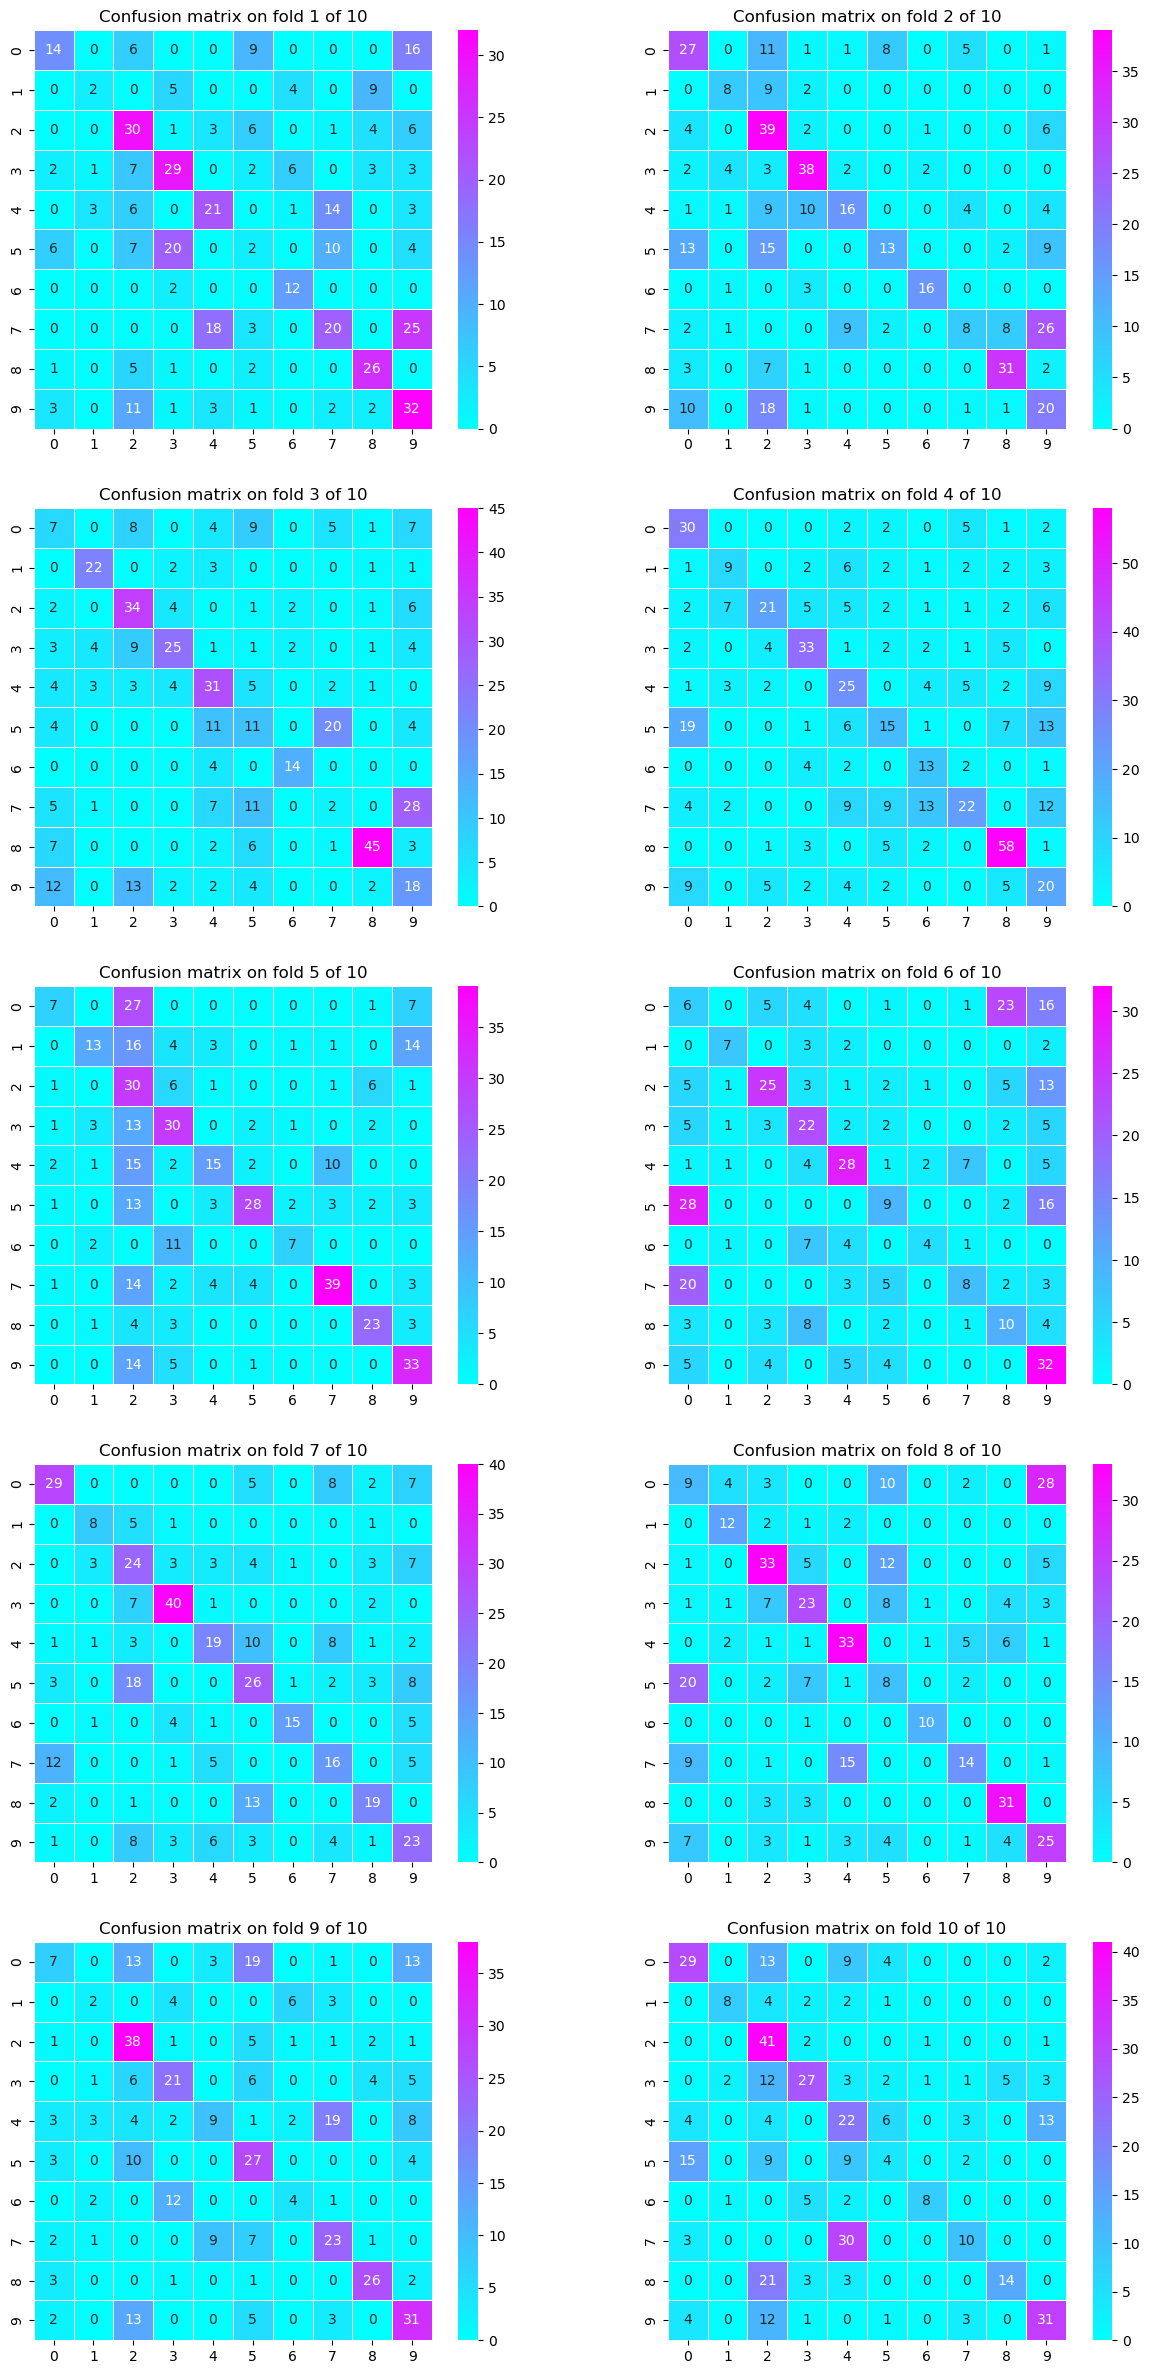

In [61]:
fig, ax =plt.subplots(5, 2, figsize=(15,3*len(fold_metrics)))

for i in range(len(fold_metrics)):
    cm = fold_metrics[i].get('confusion_matrix')
    ax[i//2,i%2].set_title('Confusion matrix on fold '+str(i+1)+' of 10')
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'cool', ax=ax[i//2,i%2])

plt.show()

### Sum of all confusion matrices with percentages:

<Axes: title={'center': 'Confusion matrix: Sum of all folds'}>

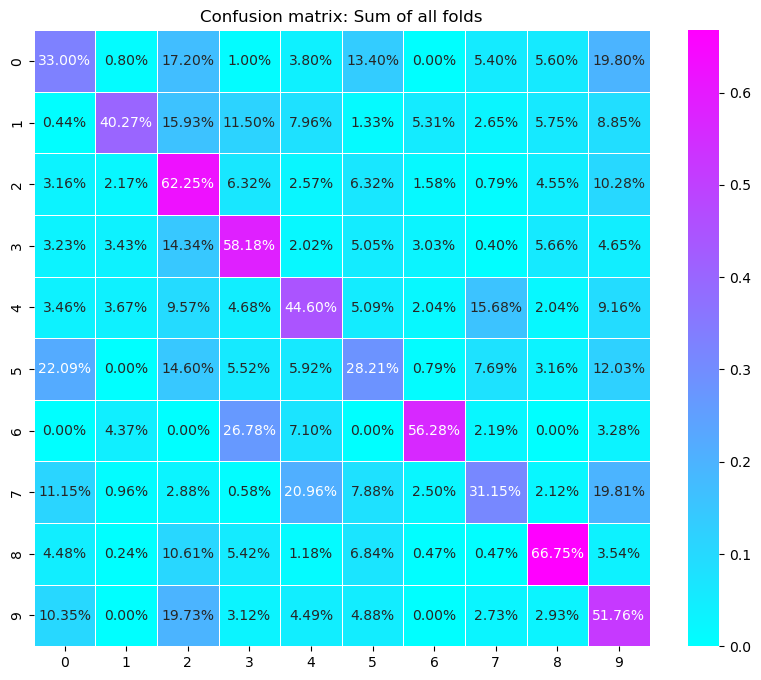

In [62]:
cm = np.zeros(shape=(10,10))
for i in fold_metrics:
    cm += i.get('confusion_matrix')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax =plt.subplots(1, 1, figsize=(10,8))
ax.set_title('Confusion matrix: Sum of all folds')
ax.invert_yaxis()
sns.heatmap(cm, annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'cool', ax=ax)

Although some folds had lower performances than others, the overall accuracy of the model for this predictive task is relatively moderate.
In particular, the classes 0, 5 and 7 reveal to be the most challengings for the LSTM to classify correctly. Failing 27% of the time, the LSTM model would classify a Gun Shot as being a Dog barking, this might be due to the reduced amount of samples from this particular class, when compared with the rest of them.


## Conclusions


In conclusion, the LSTM model shows relatively good results.


In future iterations of this project, the group would explore different combinations of Number of Epochs and Batch sizes, since we were able to run 50 epochs, with a fairly low overfitting, the group also believes that if the model were to be trained during a longer period of time, the results of from the testing and validation set would keep improving.


Furthermore, one topic that wasn't developed during this project was the use of Transfer Learning techniques. It is believed that these methods would be able to further enhance our model. Meaning that by using Pre-Trained models we could tailor them to this project's  classification problem.


On another note, the biggest challenges the group faced was the extensive period of time needed to fully run each model. This caused the hyper tuning of the LSTM to be a very tedious and monotonous work, since every model was runned locally.




## Bibliography & Sources

- Adams, S. (2018). Deep Learning for Audio Classification - YouTube. [online] www.youtube.com. Available at: https://youtube.com/playlist?list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P&si=WBmycrLWFbnN4SUo [Accessed 20 Nov. 2023].

- Gimeno, P., Viñals, I., Ortega, A., Miguel, A. and Lleida, E. (2020). Multiclass audio segmentation based on recurrent neural networks for broadcast domain data. EURASIP Journal on Audio, Speech, and Music Processing, [online] 2020(1). doi:https://doi.org/10.1186/s13636-020-00172-6.

- Lezhenin, I., Bogach, N. and Pyshkin, E. (2019). Urban Sound Classification using Long Short-Term Memory Neural Network. Proceedings of the 2019 Federated Conference on Computer Science and Information Systems, 18. doi:https://doi.org/10.15439/2019f185.

- Loye, G. (2019). Beginner’s Guide on Recurrent Neural Networks with PyTorch. [online] FloydHub Blog. Available at: https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/ [Accessed 27 Nov. 2023].

- Phan, H., Koch, P., Katzberg, F., Maass, M., Mazur, R. and Mertins, A. (2017). Audio Scene Classification with Deep Recurrent Neural Networks. [online] Available at: https://arxiv.org/pdf/1703.04770.pdf [Accessed 26 Nov. 2023].

- Salamon, J. (2019). UrbanSound8K. [online] Urban Sound Datasets. Available at: https://urbansounddataset.weebly.com/urbansound8k.html [Accessed 30 Oct. 2023].

- Team, K. (n.d.). Keras documentation: Keras layers API. [online] keras.io. Available at: https://keras.io/api/layers/ [Accessed 20 Nov. 2023].Vaj, T. (2023). 

- MFCC vs Mel Spectrogram. [online] Medium. Available at: https://vtiya.medium.com/mfcc-vs-mel-spectrogram-8f1dc0abbc62 [Accessed 28 Nov. 2023].

- Velardo , V. (2020). Deep Learning (for Audio) with Python. [online] www.youtube.com. Available at: https://www.youtube.com/watch?v=fMqL5vckiU0&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&pp=iAQB [Accessed 26 Nov. 2023].